# Week4授業前課題2 住宅価格の予測
Week3で使用したアイオワ州エイムズ市の住宅価格データセットを使い、回帰問題を解く練習をします。<br>
<br>
79種類の特徴量（説明変数）を活用し、住宅価格の数値を推測する問題が設定できます。こういった連続値のものを推測する問題を回帰問題と呼びます。

#### 今回使う手法の一覧
scikit-laernを使い以下の手法で学習と推定を行っていきます。それぞれの手法についての詳細は今の段階では扱いません。ライブラリを使えばどれも気軽に利用できることや、手法毎の結果に違いがあることを簡単に見ていきます。<br>
<br>
- 線形回帰
- SVM
- 決定木
- ランダムフォレスト<br>

<br>
分類問題と回帰問題の両方で使える手法と、そうではない手法が存在します。

#### 練習のための準備
このデータセットには79種類の特徴量（目的変数）がありますが、Week3で探索して分かったように様々なタイプのデータ含まれています。これをどう前処理するかということは機械学習において重要な箇所ですが、今回は回帰問題の学習や評価の練習を優先するため、説`GrLivArea`と`YearBuilt`の2つだけを利用することにします。

## 【問題1】練習のために特徴量の選択
データセットを読み込んだ後、`GrLivArea`と`YearBuilt`を抜き出してください。

In [1]:
# データセット取得
import numpy as np
import pandas as pd

train = pd.read_csv('/Users/tamiyagt/Documents/DIVE INTO CODE/02_Kaggle/house prices/train.csv')
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

print("data import completed")

#GrLivArea、YearBuilt、SalePriceを抽出
home_data = train.loc[:, ['GrLivArea', 'YearBuilt', 'SalePrice']]
home_data.head()

data import completed


,GrLivArea,YearBuilt,SalePrice
0,1710,2003,208500
1,1262,1976,181500
2,1786,2001,223500
3,1717,1915,140000
4,2198,2000,250000


## 【問題2】線形回帰による推定と評価
データを簡単に分析、前処理し、**線形回帰**による学習、推定、評価、可視化までの一連の流れを作成・実行してください。<br>
<br>
[sklearn.linear_model.LinearRegression — scikit-learn 0.22.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)<br>

<br>

評価のための指標値は回帰問題では**平均二乗誤差（Mean Squared Error, MSE）**を使うことが一般的です。<br>
<br>
[sklearn.metrics.mean_squared_error — scikit-learn 0.22.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)<br>
<br>
可視化は横軸にある特徴量、縦軸に推測した住宅価格といった方法で行えます。

In [2]:
home_data.isnull().sum()

GrLivArea    0
YearBuilt    0
SalePrice    0
dtype: int64

>抽出データに欠損値は無い。

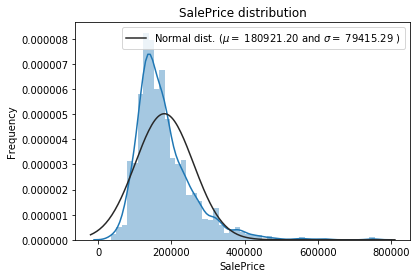

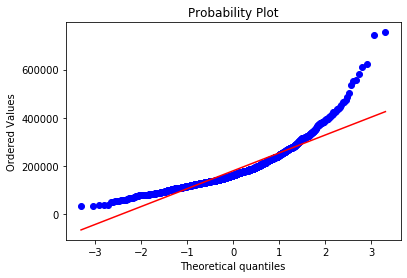

In [2]:
#SalePriceの分布およびQQプロットを描画

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm

sns.distplot(home_data['SalePrice'], fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(home_data['SalePrice'])

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(home_data['SalePrice'], plot=plt)
plt.show()

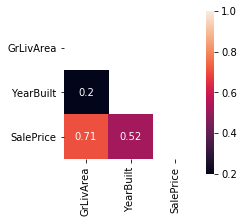

In [4]:
# 相関係数のヒートマップを出力

%matplotlib inline

home_data_corr = home_data.corr()

fig = plt.figure(figsize=(3,3))

#ヒートマップの重複する右上半分をマスク
mask = np.triu(np.ones_like(home_data_corr, dtype=np.bool))
sns.heatmap(home_data_corr, mask=mask, annot=True, square='equal')

plt.show()

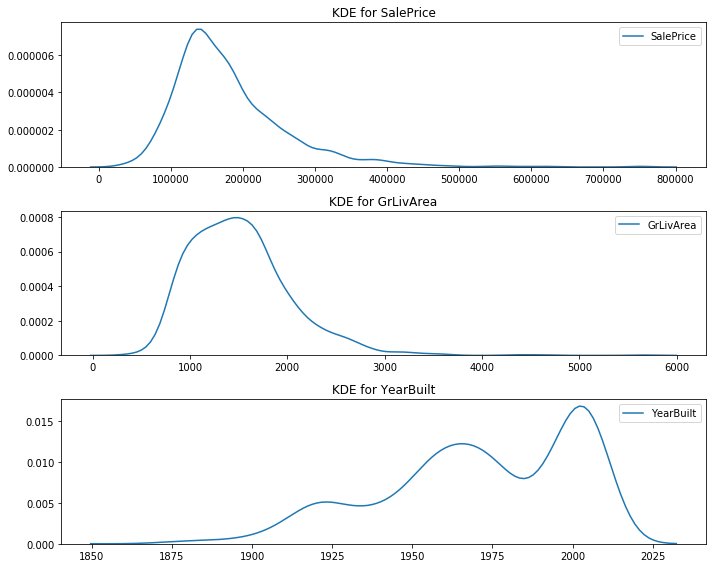

In [5]:
# 各変数のkde分布を出力

fig, axs = plt.subplots(3, 1, figsize=(10,8))

sns.kdeplot(home_data['SalePrice'], ax=axs[0])
sns.kdeplot(home_data['GrLivArea'], ax=axs[1])
sns.kdeplot(home_data['YearBuilt'], ax=axs[2])

axs[0].set_title("KDE for SalePrice")
axs[1].set_title("KDE for GrLivArea")
axs[2].set_title("KDE for YearBuilt")


plt.tight_layout(w_pad=2.5)
plt.show()

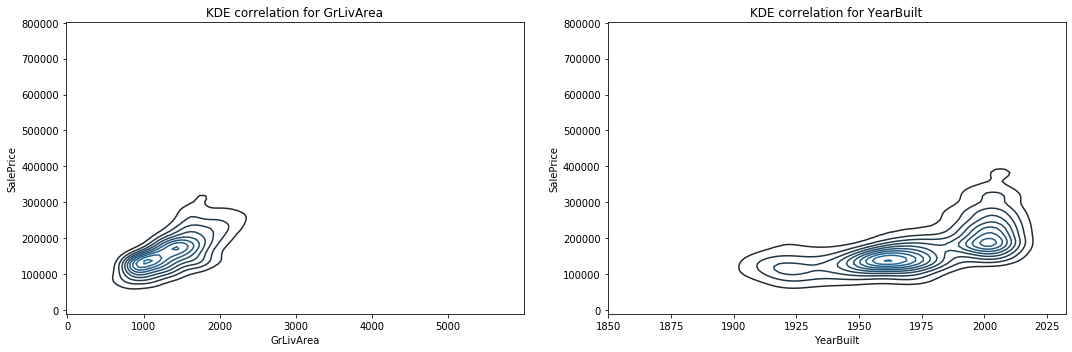

In [6]:
# 物件価格との2次元KDE図を出力
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(15,5))

sns.kdeplot(home_data['GrLivArea'], home_data['SalePrice'], ax=axs[0])
sns.kdeplot(home_data['YearBuilt'], home_data['SalePrice'], ax=axs[1])

axs[0].set_title("KDE correlation for GrLivArea")
axs[1].set_title("KDE correlation for YearBuilt")


plt.tight_layout(w_pad=2.5)
plt.show()

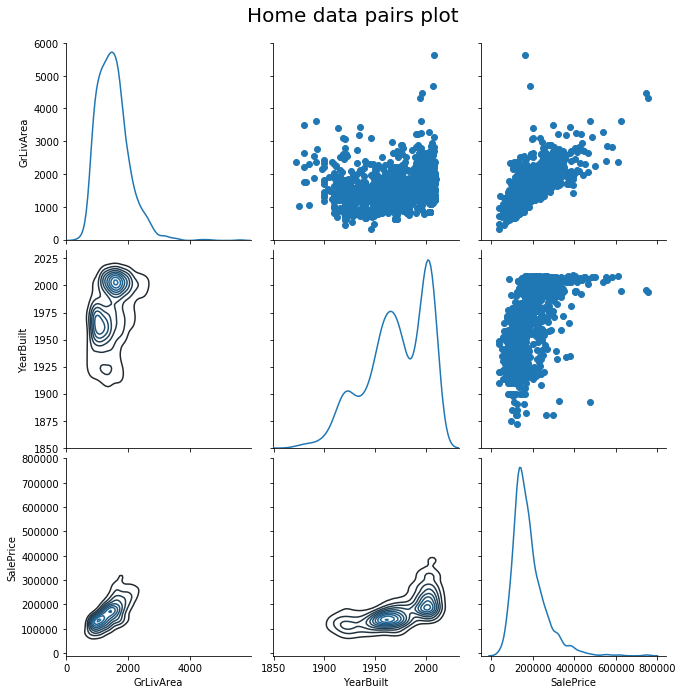

In [7]:
# 上記図をpairgridで一度に描画
# ソースコードはkaggle kernelより取得

# Create the pairgrid object
grid = sns.PairGrid(data = home_data, height = 3, diag_sharey=False) 

# Upper is a scatter plot
grid.map_upper(plt.scatter)
# Diagonal is a histogram
grid.map_diag(sns.kdeplot)
# Bottom is density plot
grid.map_lower(sns.kdeplot)

plt.suptitle('Home data pairs plot', fontsize=20, y=1.05)

plt.show()

In [3]:
# DataFrameをndarrayに変換

X = np.array(home_data.iloc[:, :-1])
y = np.array(home_data.iloc[:, -1])

print(X.shape)
print(y.shape)

(1460, 2)
(1460,)


In [4]:
# データの分割（今回は7：3の割合）

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print(X_train.shape)
print(y_train.shape)

(1022, 2)
(1022,)


In [5]:
# 標準化処理

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

print("standardization completed")

standardization completed


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 学習および推定
lin_reg = LinearRegression()

lin_reg.fit(X_train_std, y_train)
y_pred = lin_reg.predict(X_test_std)

# 推定結果の評価
print("MSE：{:.2f}".format(mean_squared_error(y_test, y_pred)))

MSE：2491254317.01


>MSE値が予想以上に高い。

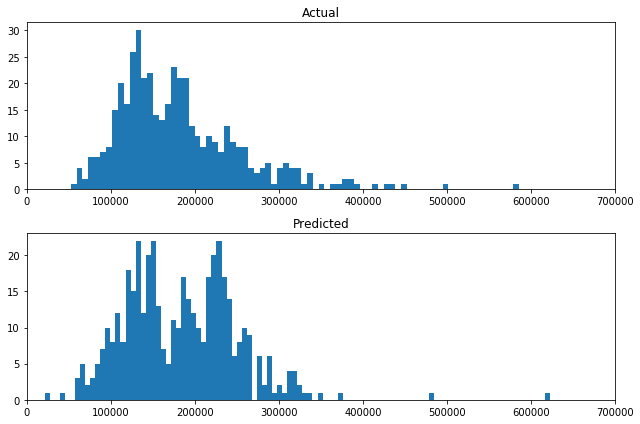

In [7]:
fig, axs = plt.subplots(2, figsize=(9,6))

axs[0].hist(y_test, bins=100)
axs[1].hist(y_pred, bins=100)

axs[0].set_title("Actual")
axs[0].set_xlim(0, 700000)
axs[1].set_title("Predicted")
axs[1].set_xlim(0, 700000)

plt.tight_layout()

>念のため、予測値の分布も確認するが、こちらも多くが外れていることが分かる。

>非常に大きなMSE値を示したため、改めて学習方法について調査をする。<br>
>結果、線形回帰学習はデータが正規分布に近いほど精度が上がることが判った。Week3で習った対数変換処理を行い、再度学習し直す。<br>
><br>
>追記：対数変換処理はMinMaxScalerでも実施できる。

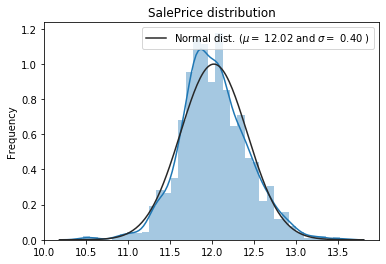

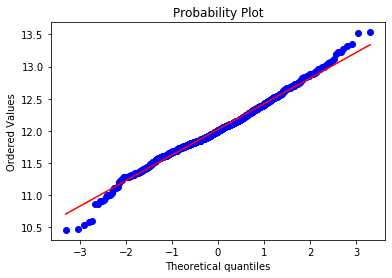

In [8]:
# 対数変換処理し、分布を再確認
y_log = np.log(y)

sns.distplot(y_log, fit=norm)

(mu, sigma) = norm.fit(y_log)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(y_log, plot=plt)
plt.show()

In [9]:
# 改めてデータを分割する

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.3)

print(X_train.shape)
print(y_train.shape)

(1022, 2)
(1022,)


In [39]:
# 学習および推定
lin_reg = LinearRegression(normalize=True)

lin_reg.fit(X_train_std, y_train)
y_pred = lin_reg.predict(X_test_std)

# 推定結果の評価
print("MSE：{}".format(mean_squared_error(y_test, y_pred)))

MSE：0.13817534469634185


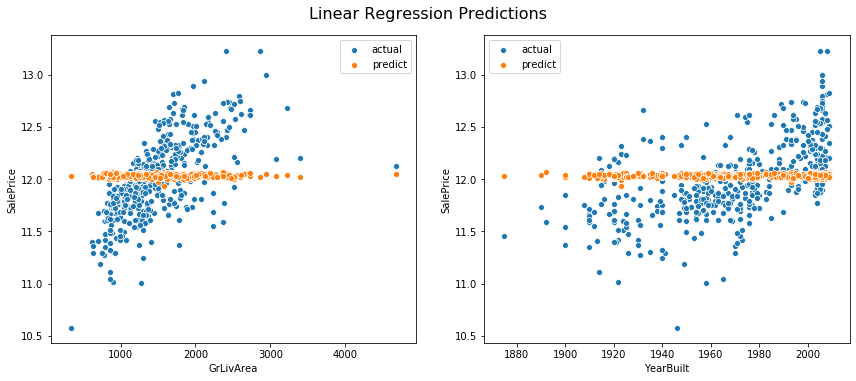

In [40]:
# 予測値を描画

fig, axs = plt.subplots(1, 2, figsize=(12,5))

fig.suptitle("Linear Regression Predictions", fontsize=16, y=1.05)

sns.scatterplot(X_test[:,0], y_test, ax=axs[0], label="actual")
sns.scatterplot(X_test[:,0], y_pred, ax=axs[0], label="predict")
sns.scatterplot(X_test[:,1], y_test, ax=axs[1], label="actual")
sns.scatterplot(X_test[:,1], y_pred, ax=axs[1], label="predict")

axs[0].set_xlabel("GrLivArea")
axs[0].set_ylabel("SalePrice")
axs[1].set_xlabel("YearBuilt")
axs[1].set_ylabel("SalePrice")

plt.tight_layout(w_pad=2.5)
plt.show()

## 【問題3】手法の比較
以下の全ての手法について学習・推定・評価・可視化を行ってください。そして、指標値を１つの表にまとめてください。その表と可視化した図を利用して結果を簡単に考察してください。どの手法がどの指標値が良かったかや、どういった図になっていたかを述べてください。<br>
<br>
- 線形回帰
- SVM
- 決定木
- ランダムフォレスト<br>
<br>

SVM、決定木、ランダムフォレストは分類問題でも使用した手法ですが、回帰問題用のライブラリはそれぞれ専用のものに分かれています。

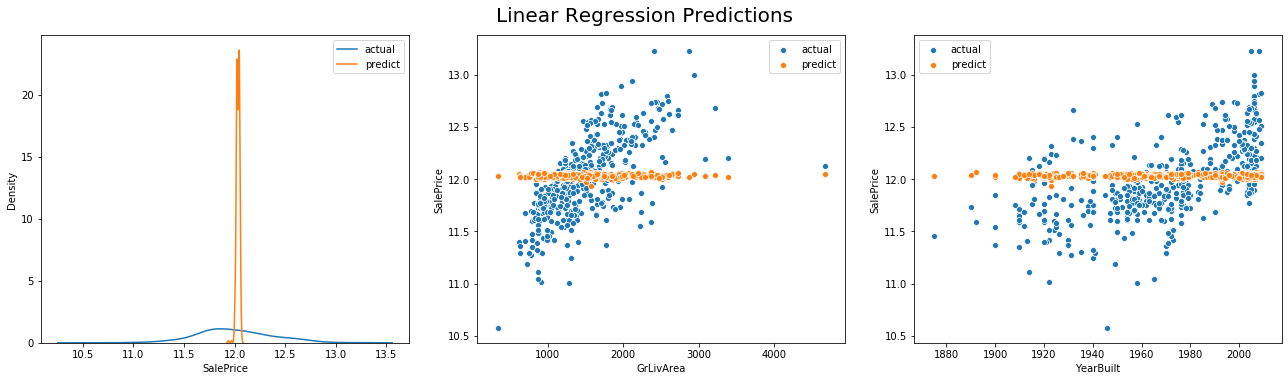

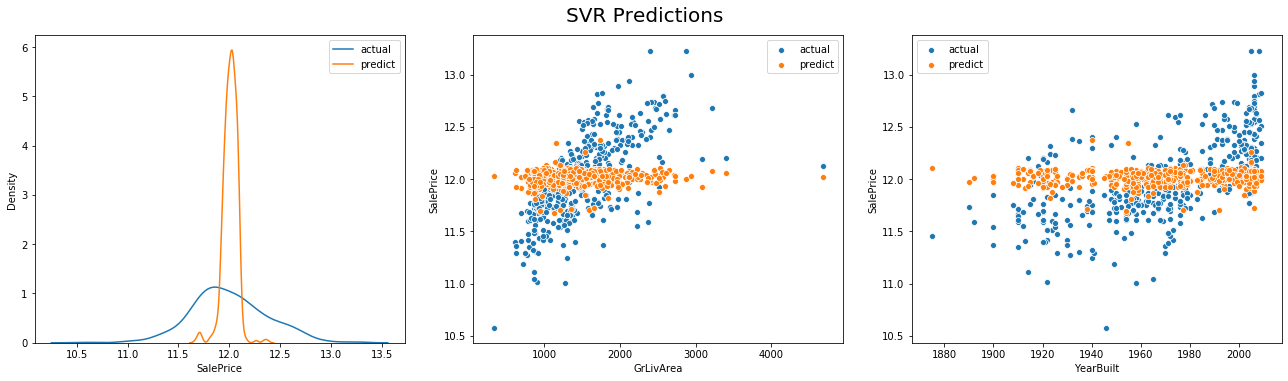

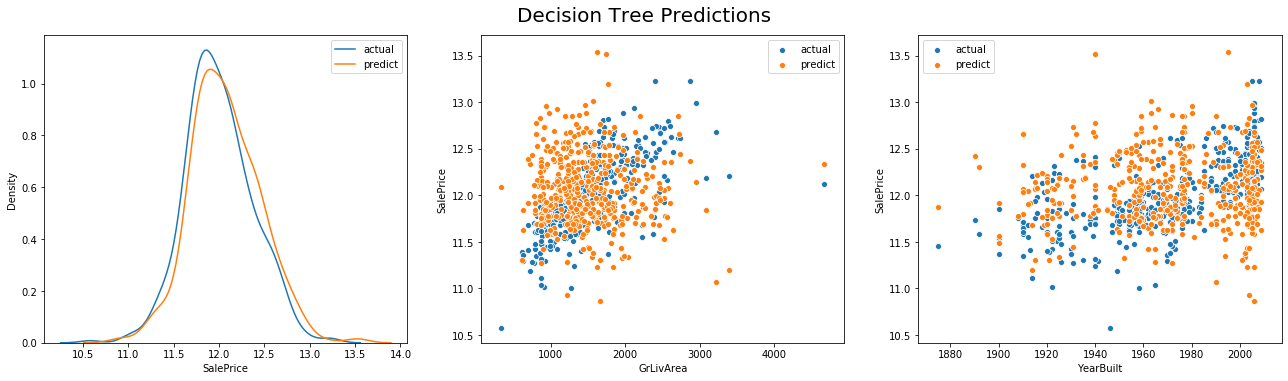

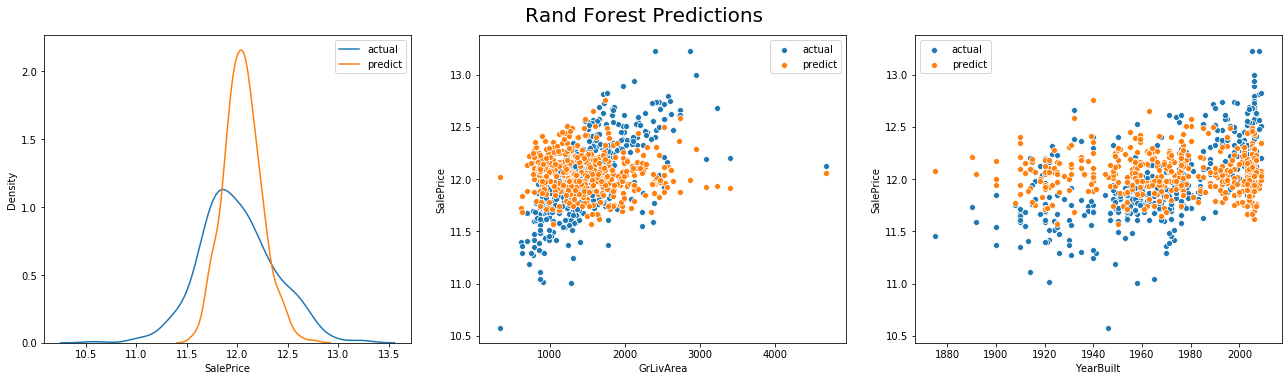

,MSE
Linear Regression,0.138175
SVR,0.139214
Decision Tree,0.289180
Rand Forest,0.177907


In [38]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

lin_reg = LinearRegression()
svr = SVR()
tree = DecisionTreeRegressor()
forest = RandomForestRegressor()

models = [lin_reg, svr, tree, forest]
labels = ['Linear Regression', 'SVR', 'Decision Tree', 'Rand Forest']

report = pd.DataFrame(columns=['MSE'])

for model, label in zip(models, labels):
    
    # 学習と推定
    model.fit(X_train_std, y_train)
    y_pred = model.predict(X_test_std)

    # 評価をreport dfに格納
    report.loc[label] = [mean_squared_error(y_test, y_pred)]
    
    # 可視化
    fig, axs = plt.subplots(1, 3, figsize=(18,5))

    fig.suptitle("{} Predictions".format(label), fontsize=20, y=1.05)

    sns.kdeplot(y_test, ax=axs[0], label="actual")
    sns.kdeplot(y_pred, ax=axs[0], label="predict")
    sns.scatterplot(X_test[:,0], y_test, ax=axs[1], label="actual")
    sns.scatterplot(X_test[:,0], y_pred, ax=axs[1], label="predict")
    sns.scatterplot(X_test[:,1], y_test, ax=axs[2], label="actual")
    sns.scatterplot(X_test[:,1], y_pred, ax=axs[2], label="predict")
    
    axs[0].set_xlabel("SalePrice")
    axs[0].set_ylabel("Density")
    axs[1].set_xlabel("GrLivArea")
    axs[1].set_ylabel("SalePrice")
    axs[2].set_xlabel("YearBuilt")
    axs[2].set_ylabel("SalePrice")

    plt.tight_layout(w_pad=2.5)
    plt.show()
    
report

>本課題で使用したモデルのうち、LinearRegressionが最も良いMSE値を示し、DecisionTreeが最も悪い値を示した。予測値の分布ではDecisionTreeがかなり精度が高いように見えるが、今回の評価方法がMSEのため、予測値の分布が正解に近似していても、各予測値が正解から離れていると思われる。

## 【問題4】（アドバンス課題）他の特徴量も使用しての学習
ここまでは練習のために2つの特徴量だけを使いましたが、他の特徴量を加えるとどのようになるか検証してください。どう選択・加工するかにはデータ分析が重要になってきます。

>前回の課題（week3課題2）の調査結果のうち、SalePriceと相関の強いOverallQual、GarageCarsとTotalBsmtSFを加えて分析を行う。GarageCarsとGarageAreaについてだが、この二つは強く相関しているため、一つで十分と考えられる。よって、よりSalePriceと相関を示したGarageCarsを採用。

In [8]:
# SalePriceとの相関を再確認
train_corr = np.abs(train.iloc[:,1:].corr())

saleprice_corr_sort = train_corr.sort_values(by='SalePrice', ascending=False)
print(saleprice_corr_sort['SalePrice'].head(11))

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64


In [14]:
# データフレームを作成
home_data2 = train.loc[:, ['OverallQual', 'GrLivArea', 'YearBuilt',
                           'GarageCars', 'TotalBsmtSF', 'SalePrice']]
home_data2.columns

Index(['OverallQual', 'GrLivArea', 'YearBuilt', 'GarageCars', 'TotalBsmtSF',
       'SalePrice'],
      dtype='object')

>特徴量の前処理による効果を確認するため、一旦モデルに学習させてみる。

In [15]:
# データを分割
from sklearn.model_selection import train_test_split

X = np.array(home_data2.iloc[:, :-1]).copy()
y = np.array(home_data2.iloc[:, -1]).copy()

# SalePriceを対数変換
y_log = np.log(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.3)

print(X_train.shape)
print(y_train.shape)

(1022, 5)
(1022,)


In [16]:
# データを標準化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

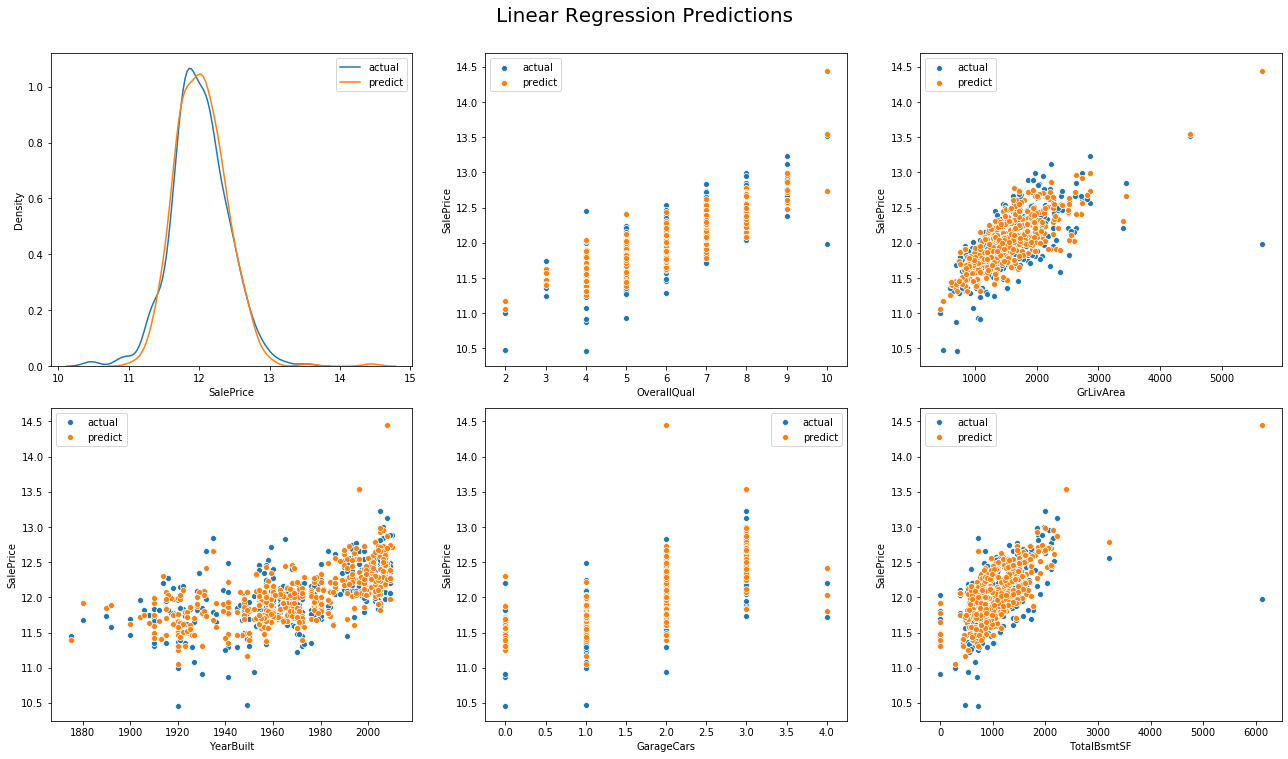

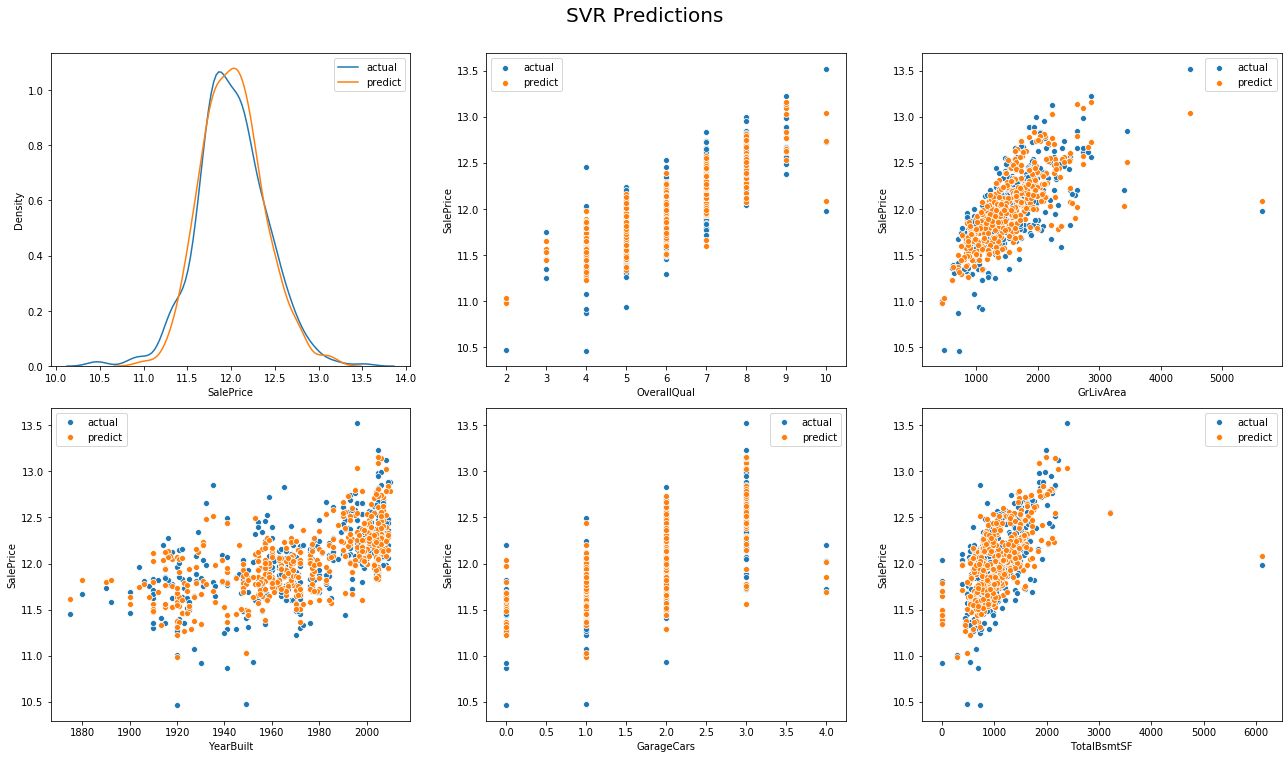

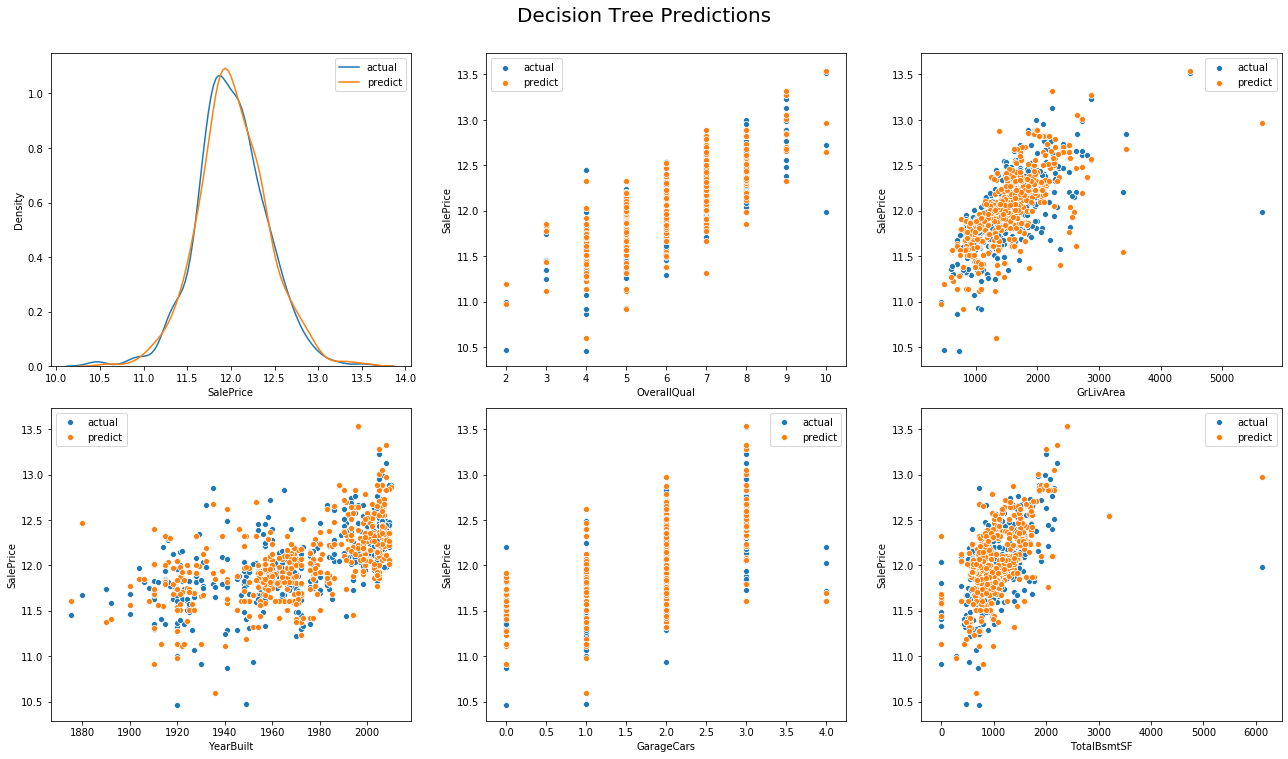

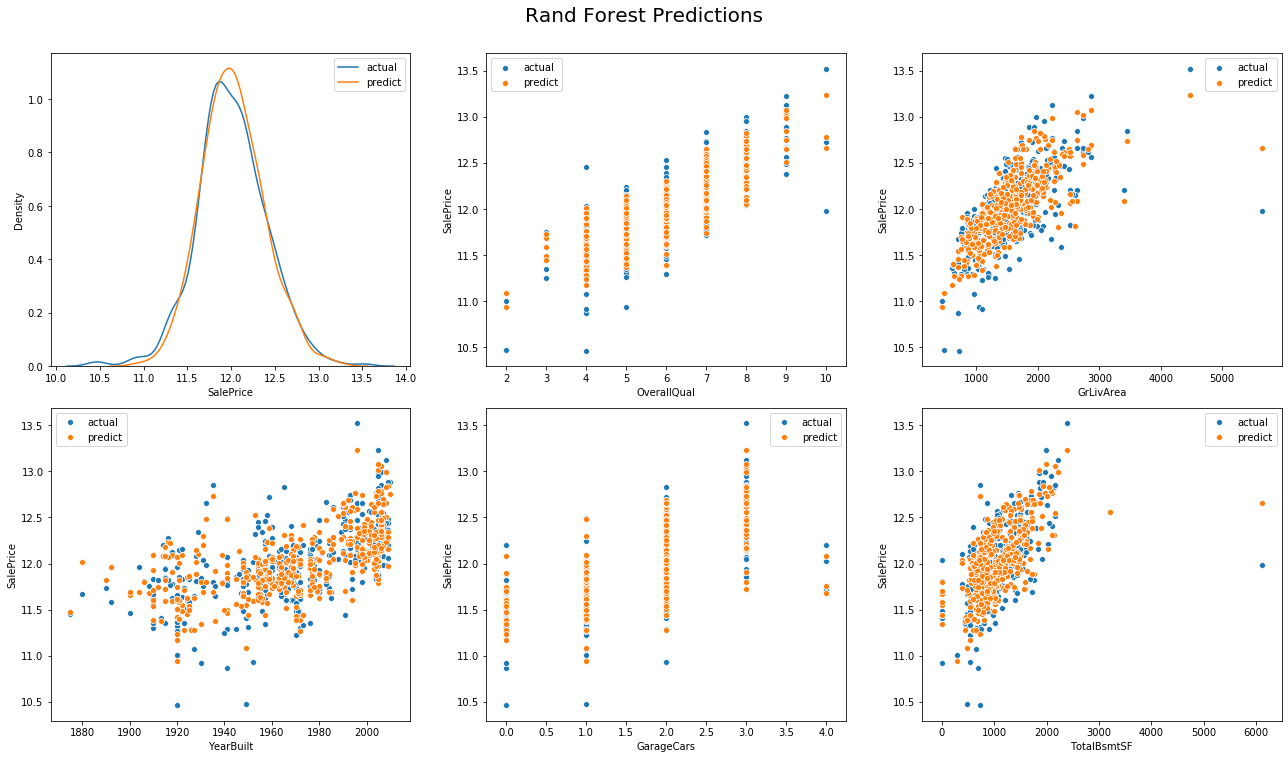

,MSE
Linear Regression,0.039020
SVR,0.026865
Decision Tree,0.058452
Rand Forest,0.028746


In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
svr = SVR()
tree = DecisionTreeRegressor()
forest = RandomForestRegressor()

models = [lin_reg, svr, tree, forest]
labels = ['Linear Regression', 'SVR', 'Decision Tree', 'Rand Forest']
features = ['OverallQual', 'GrLivArea', 'YearBuilt', 'GarageCars', 'TotalBsmtSF']

report = pd.DataFrame(columns=['MSE'])

for model, label in zip(models, labels):
    
    # 学習と推定
    model.fit(X_train_std, y_train)
    y_pred = model.predict(X_test_std)

    # 評価をreport dfに格納
    report.loc[label] = [mean_squared_error(y_test, y_pred)]
    
    # 可視化
    fig = plt.figure(figsize=(18,10))

    fig.suptitle("{} Predictions".format(label), fontsize=20, y=1.05)

    plt.subplot(2, 3, 1)
    sns.kdeplot(y_test, label="actual")
    sns.kdeplot(y_pred, label="predict")
    plt.xlabel("SalePrice"); plt.ylabel("Density")
    
    for i, feature in enumerate(features):
        plt.subplot(2, 3, i + 2)
        sns.scatterplot(X_test[:,i], y_test, label="actual")
        sns.scatterplot(X_test[:,i], y_pred, label="predict")

        plt.xlabel(feature); plt.ylabel("SalePrice")

    plt.tight_layout(w_pad=2.5)
    plt.show()
    
report

>いずれの手法も特徴量を追加することにより、予測精度が上がったことが分かる。<br>
><br>
>次に特徴量のデータ処理による影響を調査する。

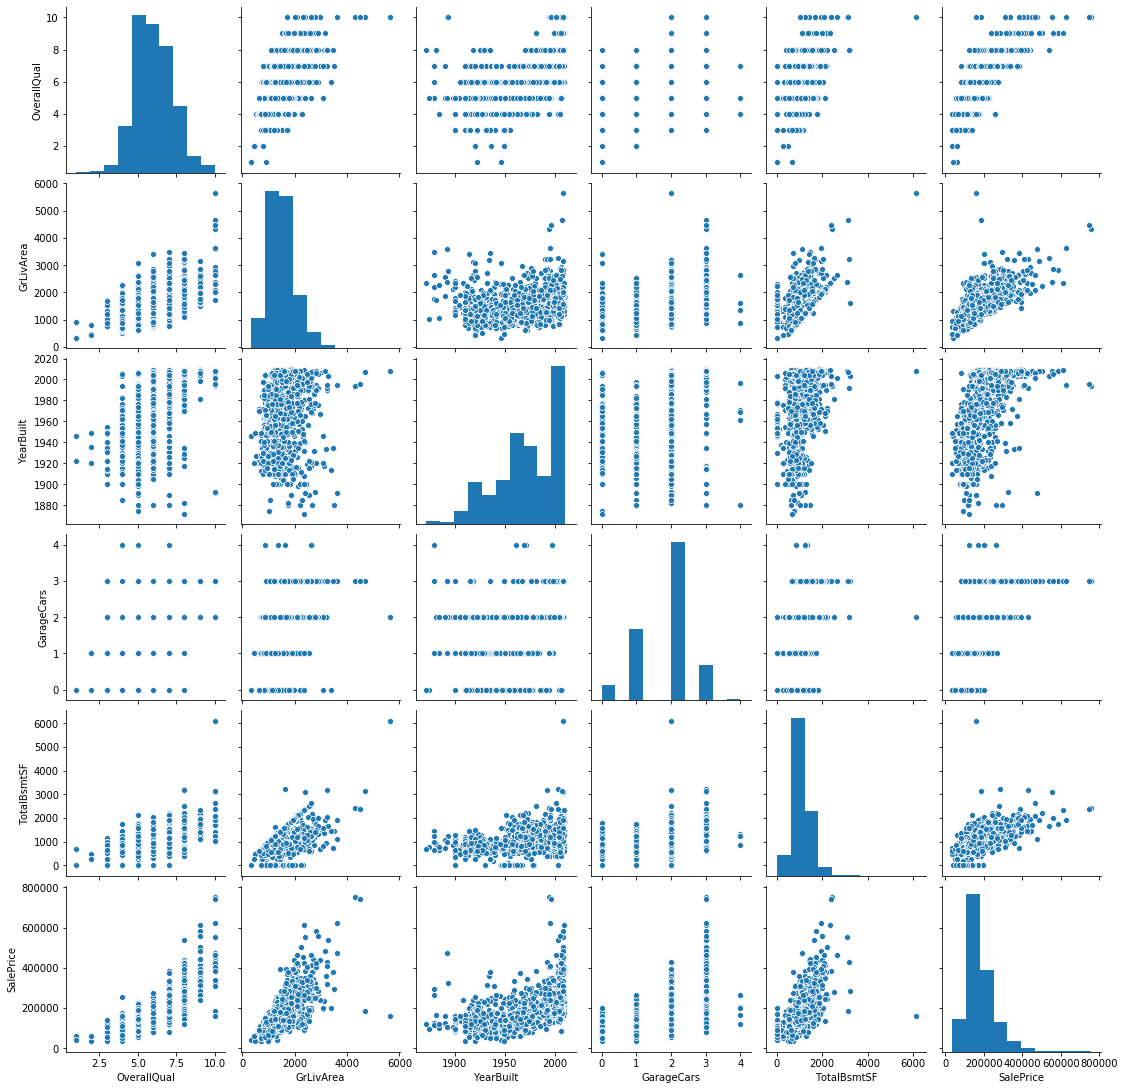

In [7]:
# 散布図行列を確認
sns.pairplot(home_data2)

>散布図行列を確認し、採用した特徴量のうち二つが質的尺度（OverallQual, GarageCars）で三つが量的尺度と分かる（GrLivArea, YearBuilt, TotalBsmtSF）<br>
><br>
>GrLivAreaおよびTotalBsmtSFには大きく外れている値の存在が確認できる。二つはGrLivAreaが4000以上にも関わらず、値段が低いサンプル。もう一つはTotalBsmtSFが約6000で値段が約200000のサンプル。これらを特定し、除外する。

In [18]:
# GrLivAreaの外れ値の特定
home_data2.loc[home_data2['GrLivArea'] > 4000]    # Index523と1298と判明

,OverallQual,GrLivArea,YearBuilt,GarageCars,TotalBsmtSF,SalePrice
523,10,4676,2007,3,3138,184750
691,10,4316,1994,3,2444,755000
1182,10,4476,1996,3,2396,745000
1298,10,5642,2008,2,6110,160000


In [19]:
# TotalBsmtSFの外れ値の特定
home_data2.loc[home_data2['TotalBsmtSF'] > 6000]    # Index1298と判明

,OverallQual,GrLivArea,YearBuilt,GarageCars,TotalBsmtSF,SalePrice
1298,10,5642,2008,2,6110,160000


In [20]:
# Index523と1298を除外
home_data2 = home_data2.drop(index=523)
home_data2 = home_data2.drop(index=1298)

>SalePriceの対数変換処理を行う。また、GrLivAreaおよびTotalBsmtSFの分布も確認し、必要であれば対数変換処理を行う。

In [21]:
# SalePriceの対数変換処理
home_data2['SalePrice'] = np.log(home_data2['SalePrice'])

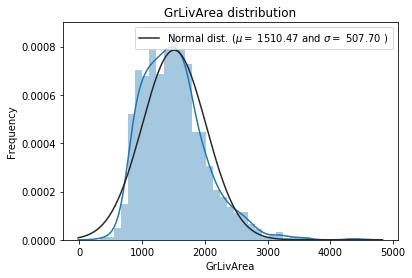

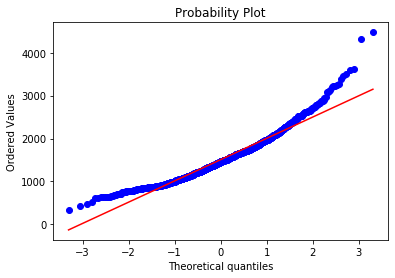

In [22]:
# GrLivAreaの分布を確認
sns.distplot(home_data2['GrLivArea'], fit=norm)

(mu, sigma) = norm.fit(home_data2['GrLivArea'])

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('GrLivArea distribution')

fig = plt.figure()
res = stats.probplot(home_data2['GrLivArea'], plot=plt)
plt.show()

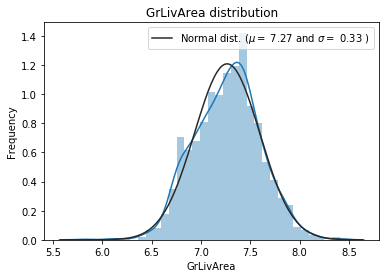

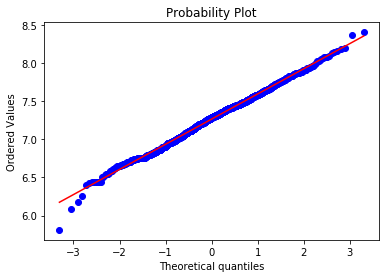

In [23]:
# GrLivAreaを対数変換処理
home_data2['GrLivArea'] = np.log(home_data2['GrLivArea'])

# 改めて分布を確認
sns.distplot(home_data2['GrLivArea'], fit=norm)

(mu, sigma) = norm.fit(home_data2['GrLivArea'])

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('GrLivArea distribution')

fig = plt.figure()
res = stats.probplot(home_data2['GrLivArea'], plot=plt)
plt.show()

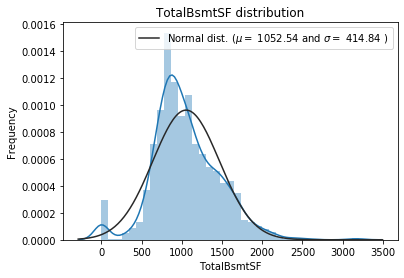

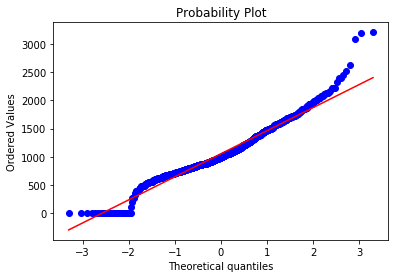

In [24]:
# TotalBsmtSFの分布を確認
sns.distplot(home_data2['TotalBsmtSF'], fit=norm)

(mu, sigma) = norm.fit(home_data2['TotalBsmtSF'])

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('TotalBsmtSF distribution')

fig = plt.figure()
res = stats.probplot(home_data2['TotalBsmtSF'], plot=plt)
plt.show()

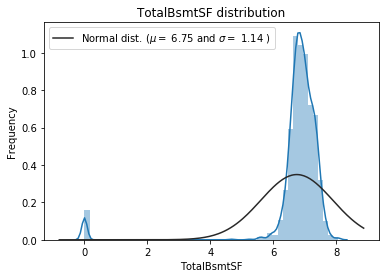

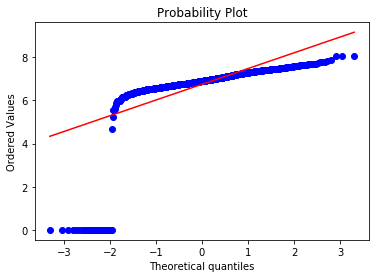

In [25]:
# TotalBsmtSFを対数変換処理
home_data2['TotalBsmtSF'] = np.log1p(home_data2['TotalBsmtSF'])

# 改めて分布を確認
sns.distplot(home_data2['TotalBsmtSF'], fit=norm)

(mu, sigma) = norm.fit(home_data2['TotalBsmtSF'])

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('TotalBsmtSF distribution')

fig = plt.figure()
res = stats.probplot(home_data2['TotalBsmtSF'], plot=plt)
plt.show()

In [26]:
# データを分割
from sklearn.model_selection import train_test_split

X = np.array(home_data2.iloc[:, :-1])
y = np.array(home_data2.iloc[:, -1])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print(X_train.shape)
print(y_train.shape)

(1020, 5)
(1020,)


In [27]:
# データを標準化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

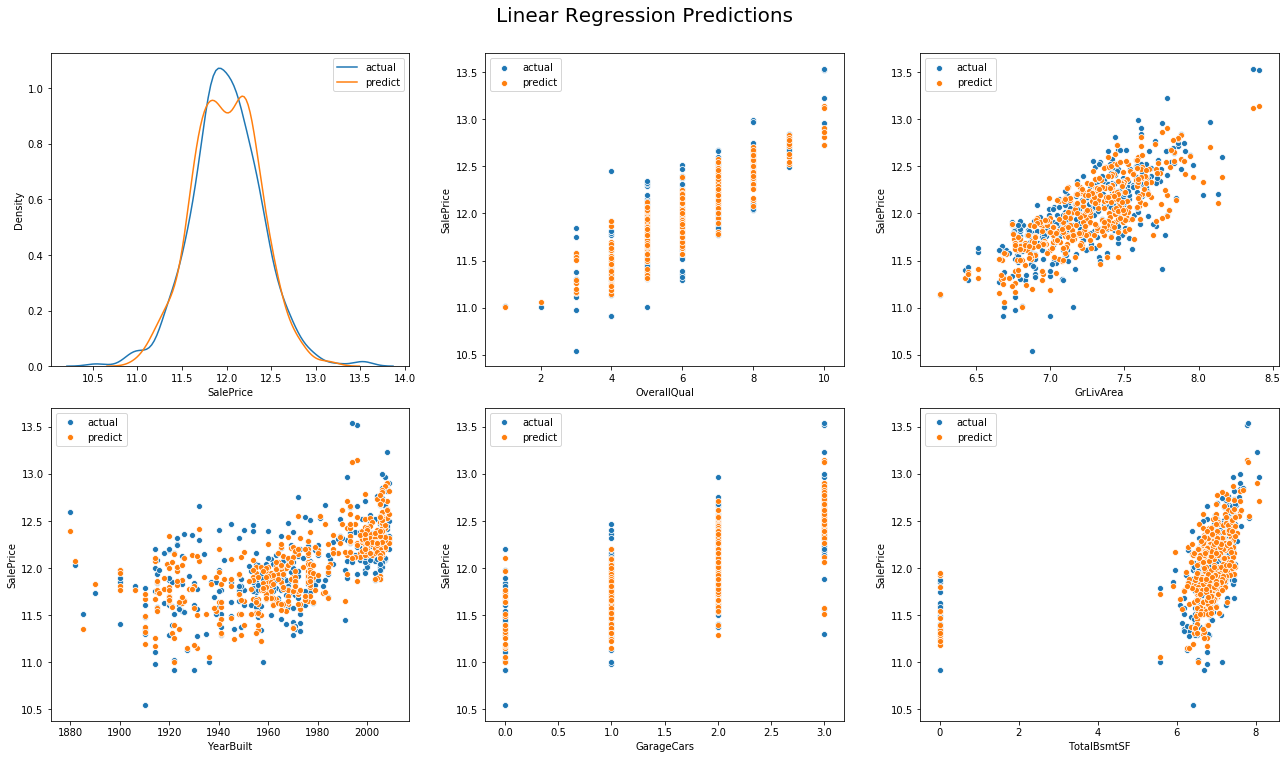

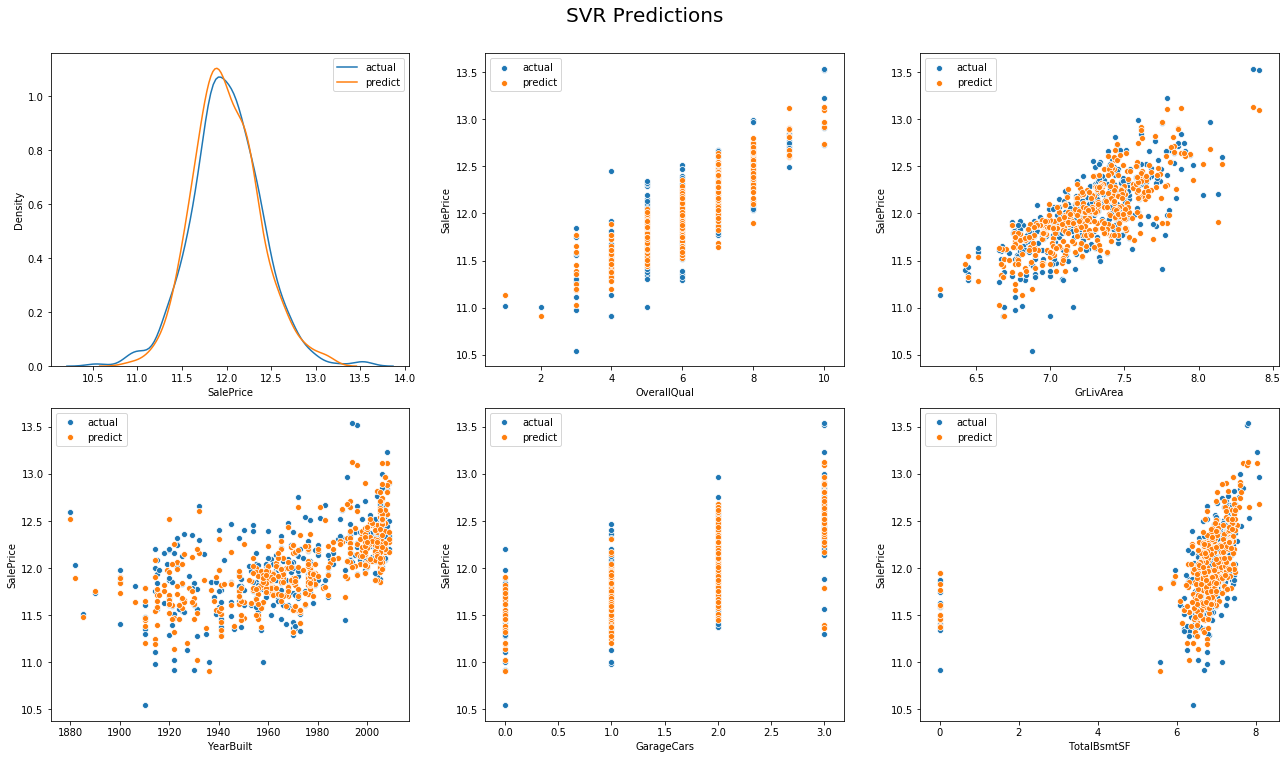

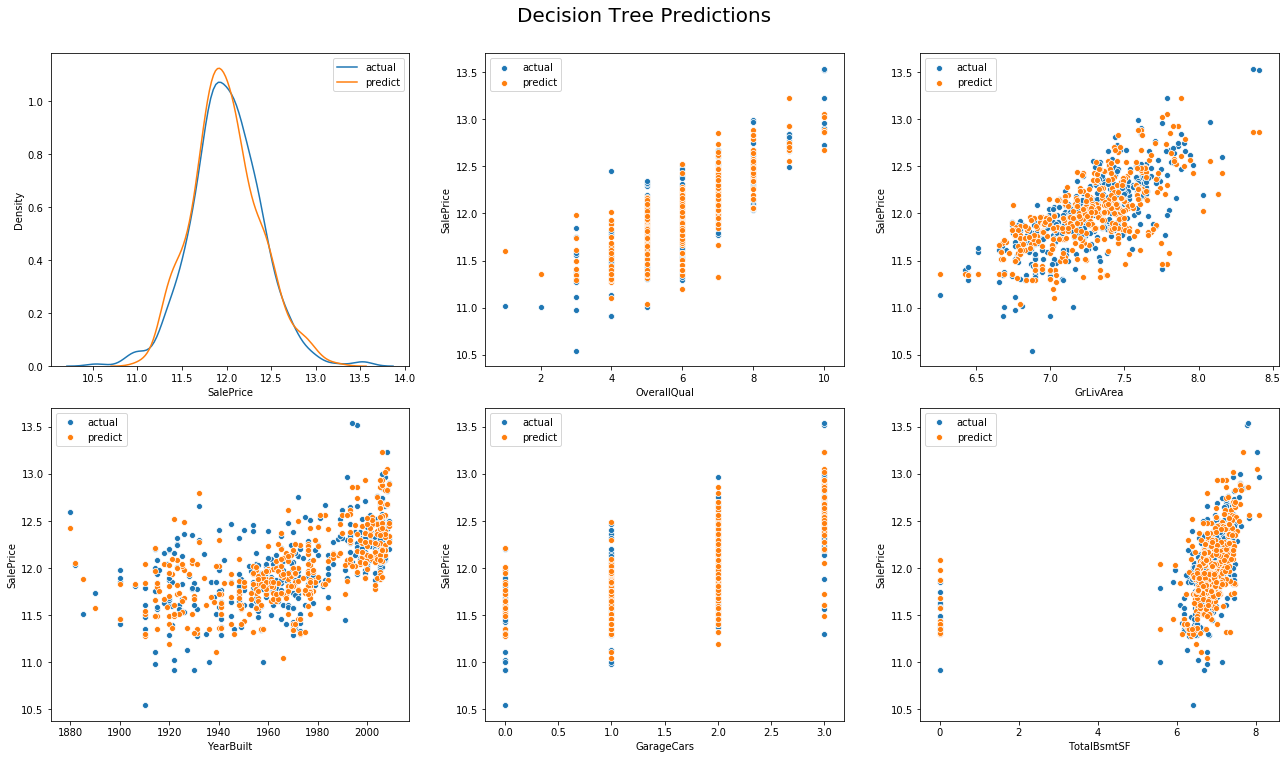

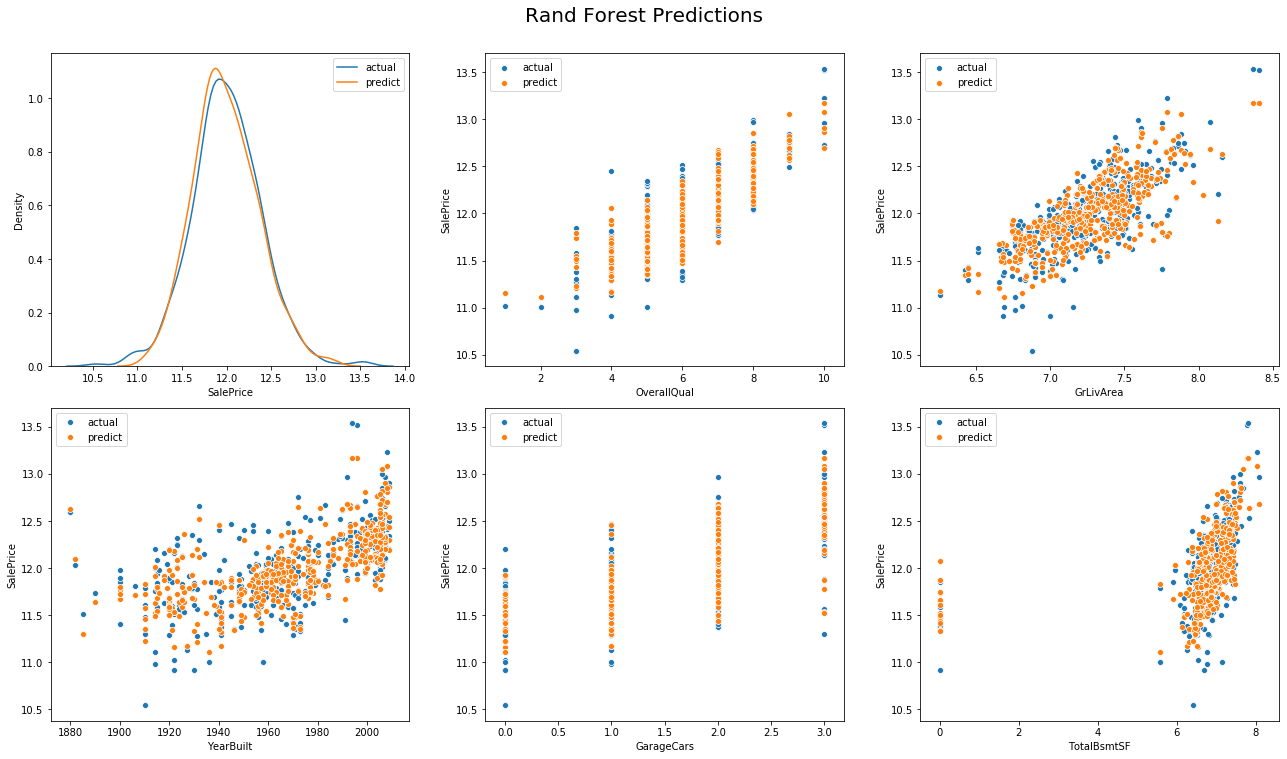

,MSE
Linear Regression,0.026268
SVR,0.024553
Decision Tree,0.052354
Rand Forest,0.027897


In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
svr = SVR()
tree = DecisionTreeRegressor()
forest = RandomForestRegressor()

models = [lin_reg, svr, tree, forest]
labels = ['Linear Regression', 'SVR', 'Decision Tree', 'Rand Forest']
features = ['OverallQual', 'GrLivArea', 'YearBuilt', 'GarageCars', 'TotalBsmtSF']

report = pd.DataFrame(columns=['MSE'])

for model, label in zip(models, labels):
    
    # 学習と推定
    model.fit(X_train_std, y_train)
    y_pred = model.predict(X_test_std)

    # 評価をreport dfに格納
    report.loc[label] = [mean_squared_error(y_test, y_pred)]
    
    # 可視化
    fig = plt.figure(figsize=(18,10))

    fig.suptitle("{} Predictions".format(label), fontsize=20, y=1.05)

    plt.subplot(2, 3, 1)
    sns.kdeplot(y_test, label="actual")
    sns.kdeplot(y_pred, label="predict")
    plt.xlabel("SalePrice"); plt.ylabel("Density")
    
    for i, feature in enumerate(features):
        plt.subplot(2, 3, i + 2)
        sns.scatterplot(X_test[:,i], y_test, label="actual")
        sns.scatterplot(X_test[:,i], y_pred, label="predict")

        plt.xlabel(feature); plt.ylabel("SalePrice")

    plt.tight_layout(w_pad=2.5)
    plt.show()
    
report

>特徴量のデータ処理を行うことにより、各手法のうちLinear Regressionの精度が上がったことが分かる。今回行った処理（＝Normalization）は回帰系の分類法に影響を与えるものと考えられる。Decision TreeやRand ForestではRegressionとは違い、各木が独自に分類を行う手法のため、データの分布は大きく影響しないのだろう。